In [1]:
%load_ext autoreload
%autoreload 2
import edhec_risk_kit as erk
import pandas as pd
import numpy as np

ind_return = erk.get_ind_returns()
tmi_return = erk.get_total_market_index_returns()

In [2]:
risky_r = ind_return['2000':][['Steel', 'Fin', 'Beer']]
risky_r.shape

(228, 3)

In [3]:
# Safe asset needs to have the same shape as Risky asset
safe_r = pd.DataFrame().reindex_like(risky_r)
safe_r.shape

(228, 3)

In [4]:
safe_r[:] = 0.03/12
start = 1000
floor = 0.8
safe_r

,Steel,Fin,Beer
2000-01,0.0025,0.0025,0.0025
2000-02,0.0025,0.0025,0.0025
2000-03,0.0025,0.0025,0.0025
2000-04,0.0025,0.0025,0.0025
2000-05,0.0025,0.0025,0.0025
...,...,...,...
2018-08,0.0025,0.0025,0.0025
2018-09,0.0025,0.0025,0.0025
2018-10,0.0025,0.0025,0.0025
2018-11,0.0025,0.0025,0.0025


1. Cushion - (Asset Value - Floor Value)
2. Compute an Allocation to Safe and Risky Assets -> M * Risk Budget
3. Recompute the Asset Value based on the Returns

In [5]:
def compound1(r):
    return (1+r).prod()-1

def compound2(r):
    return np.exp(np.log(1+r).sum())-1

def compound3(r):
    return np.expm1(np.log1p(r).sum())

# All these are equivalent

In [6]:
compound1(risky_r)

Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

In [7]:
compound2(risky_r)

Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

In [8]:
compound3(risky_r)

Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

In [9]:
%timeit (compound1) # Computes how much time it takes for a command to run

22.6 ns ± 0.115 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [10]:
%timeit (compound2)

22.6 ns ± 0.0721 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [11]:
%timeit (compound3)

22.6 ns ± 0.186 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


 Based on these results, compound3 is the fastest. Indeed, the for loop based on Python is not the most efficient one, using numpy, pandas or even in C since it is much more efficient.

# Let's implement a for loop for CPPI

In [12]:
dates = risky_r.index
n_steps = len(dates)
account_value = start
floor_value = start*floor
m = 3
account_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)

for step in range(n_steps):
    cushion = (account_value - floor_value)/account_value # In relative terms instead of absolute value
    risky_w = m*cushion
    risky_w = np.minimum(risky_w, 1) # Constraint to assure that we cannot borrow to invest into risky asset (will compare between risky_w and 0 and display the min)
    risky_w = np.maximum(risky_w, 0) # Don't go below 0 (will compare between risky_w and 0 and display the max)
    safe_w = 1-risky_w
    risky_alloc = account_value*risky_w
    safe_alloc = account_value*safe_w
    # Update the account value for this time step using the risky asset and safe asset returns
    account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
    # Save the values so I can look at the history and plot it
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w
    account_history.iloc[step] = account_value


In [13]:
account_history.head()

,Steel,Fin,Beer
2000-01,984.380000,974.480000,987.320000
2000-02,1023.292876,931.167544,922.971256
2000-03,1047.555176,998.187296,924.835988
2000-04,1042.079009,973.927479,939.993701
2000-05,1007.137753,1001.460033,991.145489


In [14]:
risky_wealth = start*(1+risky_r).cumprod()

<AxesSubplot:>

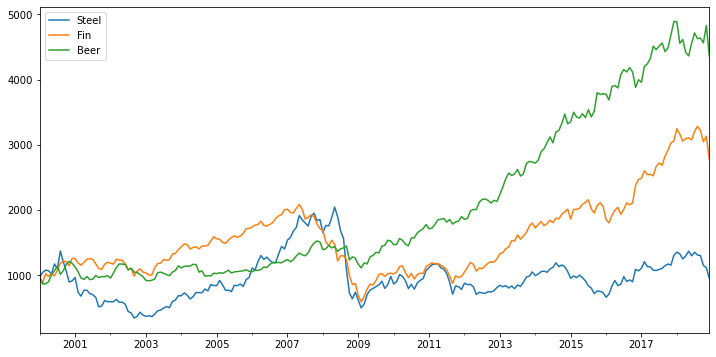

In [15]:
# Without CPPI
risky_wealth.plot(figsize=(12,6))

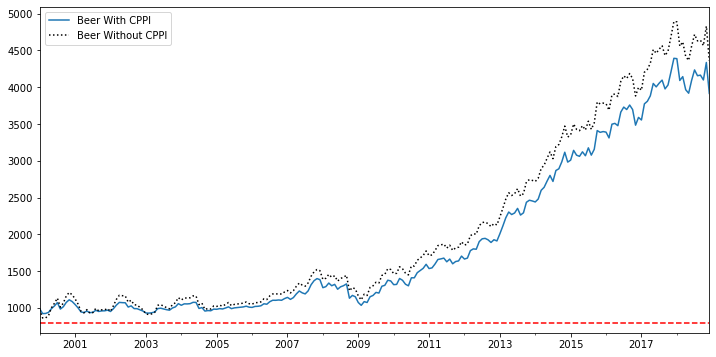

In [16]:
ax = account_history['Beer'].plot(figsize=(12,6), legend=True, label='Beer With CPPI')
risky_wealth['Beer'].plot(ax=ax, legend=True, style='k:', label='Beer Without CPPI')
ax.axhline(y=floor_value, color='r', linestyle='--')

<AxesSubplot:>

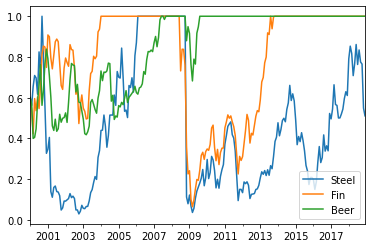

In [17]:
risky_w_history.plot()

Changes between Beer with and without CPPI is due to the fact the its weight in the CPPI varies on the early year, before beeing 100% from 2009 onwards, making it follow exactly the trend of beer without CPPI from 2009.

The floor is always the same, no update.

Maximum Drawdown can help with this.

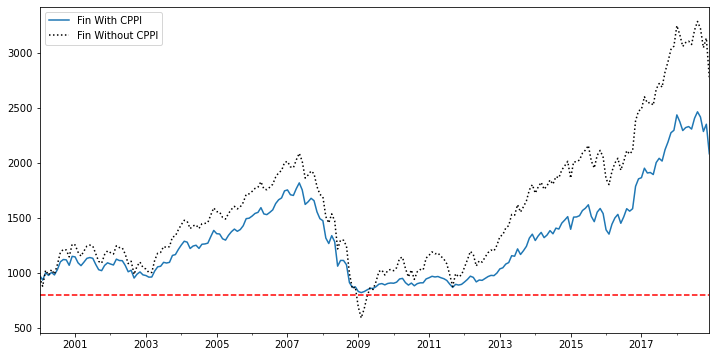

In [18]:
ind = 'Fin'
ax = account_history[ind].plot(figsize=(12,6), legend=True, label= str(ind)+' With CPPI')
risky_wealth[ind].plot(ax=ax, legend=True, style='k:', label=str(ind)+' Without CPPI')
ax.axhline(y=floor_value, color='r', linestyle='--')

In 2009, after the crash, The CPPI Portfolio does better !!

<AxesSubplot:>

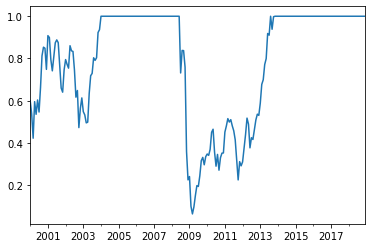

In [19]:
risky_w_history['Fin'].plot()

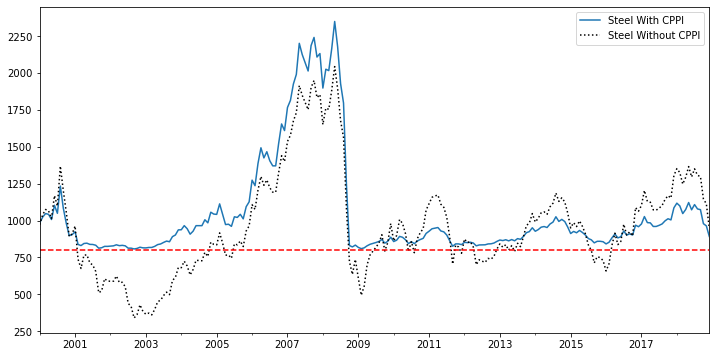

In [20]:
ind = 'Steel'
ax = account_history[ind].plot(figsize=(12,6), legend=True, label= str(ind)+' With CPPI')
risky_wealth[ind].plot(ax=ax, legend=True, style='k:', label=str(ind)+' Without CPPI')
ax.axhline(y=floor_value, color='r', linestyle='--')

WHAT A PROTECTION

<AxesSubplot:>

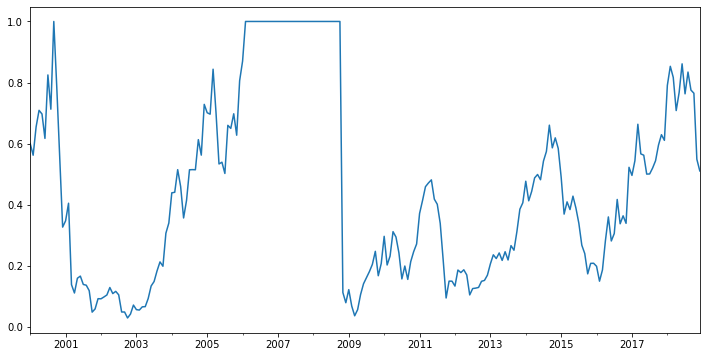

In [21]:
risky_w_history['Steel'].plot(figsize=(12,6))

In [24]:
erk.summary_stats(risky_r)

,Annualized Return,Annualized Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.002790,0.312368,-0.326334,4.144381,0.150122,0.208117,-0.102567,-0.758017
Fin,0.055166,0.192909,-0.533218,4.995534,0.091197,0.132175,0.126718,-0.718465
Beer,0.080598,0.138925,-0.493545,4.173881,0.062999,0.091442,0.354314,-0.271368


In [30]:
btr = erk.run_cppi(risky_r)
erk.summary_stats(btr['Wealth'].pct_change().dropna())

,Annualized Return,Annualized Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.005167,0.174180,-1.995143,17.110190,0.091654,0.130153,-0.196750,-0.655198
Fin,0.040894,0.131678,-0.946504,6.051414,0.065477,0.091621,0.080352,-0.549673
Beer,0.075544,0.115462,-0.669250,4.760879,0.052897,0.074908,0.383772,-0.259582


Max Drawdown is lower than the risky portfolio alone. CPPI helps for the downside, not necessarily on the upside (share ratio is actually lower for CPPI Steel compared to only Steel).

<AxesSubplot:>

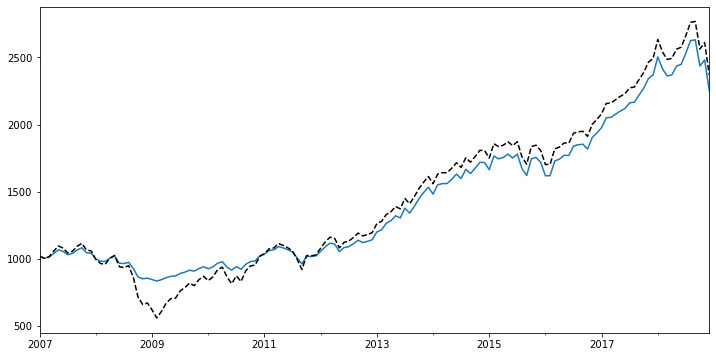

In [35]:
btr = erk.run_cppi(tmi_return['2007':])
ax = btr['Wealth'].plot(figsize=(12,6), legend=False)
btr['Risky Wealth'].plot(ax=ax, style='k--', legend=False)

In [36]:
erk.summary_stats(btr['Risky Wealth'].pct_change().dropna())

,Annualized Return,Annualized Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
R,0.073411,0.150463,-0.734939,4.523488,0.071552,0.096315,0.280618,-0.499943


In [37]:
erk.summary_stats(btr['Wealth'].pct_change().dropna())

,Annualized Return,Annualized Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
R,0.069416,0.100381,-0.588292,3.740932,0.045661,0.062953,0.382052,-0.229683


Drawdown is much lower for our CPPI Portfolio. Sharpe Ratio is also higher because of the lower volatility.

# Drawdown Constraint

In [38]:
btr = erk.run_cppi(ind_return['2007':][['Steel', 'Fin', 'Beer']], drawdown=0.25)

<AxesSubplot:>

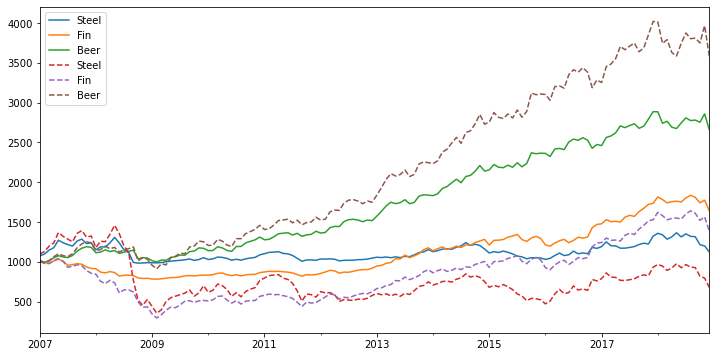

In [39]:
ax = btr['Wealth'].plot(figsize=(12,6))
btr['Risky Wealth'].plot(ax = ax, style = '--')

In [40]:
erk.summary_stats(btr['Risky Wealth'].pct_change().dropna())

,Annualized Return,Annualized Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.459951,4.782828,0.152256,0.203837,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.695200,4.621401,0.105693,0.149862,-0.012370,-0.718465
Beer,0.111554,0.127971,-0.670797,4.650878,0.056469,0.077388,0.620132,-0.271368


In [41]:
erk.summary_stats(btr['Wealth'].pct_change().dropna())

,Annualized Return,Annualized Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,0.003784,0.097073,-0.441089,5.220481,0.047362,0.066991,-0.262958,-0.248059
Fin,0.041975,0.085028,-0.355163,4.153860,0.038337,0.054111,0.136964,-0.243626
Beer,0.084375,0.086263,-0.744111,4.571533,0.037914,0.051189,0.613413,-0.161186


Here, Max Drawdowns does not exceed 25% on the CPPI constrained. Very INTERESTING !